In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.figsize'] = 8, 8
from IPython.display import Image
color = 'lightsteelblue'

In [2]:
import pymc3 as pm
import random
import numpy as np
from scipy.stats import beta, binom, bernoulli, poisson
import pandas as pd
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from collections import Counter
import theano.tensor as tt
import scipy.stats as stats
from scipy.integrate import quad

# Chapter 12: Bayesian Approaches to Testing a Point (Null) Hypothesis

NHST approaches tend to give 'answers' to the questions; the coin is fair, the coin is not fair, and so on. There are two ways to formalize this through a bayesian analysis. 
1. Estimation Approach - Does the parameter value fall among the credible values in the posterior?
2. Model Comparison Approach - Does bayesian model comparison change the posterior of a prior with with only values of interest versus a broad prior?

## Estimation Approach

A region of practical equivalence (ROPE) is a range of parameter values that are considered to be the same as the null value. The ROPE is chosen before the analysis is done. 
1. If the entire ROPE falls outside of the 95% HDI, then the parameter value is not credible.
2. If the ROPE completely contains the 95% HDI of the posterior of that parameter, then the parameter value is credible.
3. If the ROPE does not completely contain the 95% HDI, no clear distinction can be made. The current data is not suficient.
4. In the rare case that the HDI does not include the null value but is completely within the ROPE, then the ROPE is probably too large or that the available data is more precise than the ROPE.

## Model Comparison Approach

In this approach, the goal is to focus on which of two priors is least credible. One of the priors is very broad while the other is exactly the null value. By using the Bayes' Factor, it can be decided which model is more likely. Another option is to check the posterior distribution and its relationship with the ROPE. 

## Are Different Groups Equal?

One common experiment is do differences exist in groups with different conditions. Consider an experiment of memorizing words while listening to background music. Each condition has parameters $\omega_j$ and $\kappa_j$. 

In [4]:
df = pd.read_csv('music.csv')
df['CondOfSubj'] = df['CondOfSubj'].astype('category')
conversion = {1: 'Das Kruschke', 2: "Mozart", 3: 'Bach', 4: 'Beethoven'}
df['Music'] = df['CondOfSubj'].map(conversion)
CondOfSubj = df.CondOfSubj.cat.codes.as_matrix()
Number_Conditions = len(df.CondOfSubj.unique())
Number_Subjects = len(df)

In [4]:
df.groupby('Music').mean()['nCorrOfSubj']

Music
Bach            10.2
Beethoven       10.4
Das Kruschke     8.0
Mozart          10.0
Name: nCorrOfSubj, dtype: float64

Based off of the average result of the participants, it seems that subjects that listened to Das Kruschke did the worst while subjects that listened to Beethoven did the best.

In [26]:
# parameters form the book
aP, bP = 1., 1.
a0 = tt.as_tensor([.48*500, aP])      
b0 = tt.as_tensor([(1-.48)*500, bP])
aPs = [aP] * 4
bPs = [bP] * 4
a = tt.as_tensor(np.array(list(zip(aPs, [(.40*125), (.50*125), (.51*125), (.52*125)]))))
b = tt.as_tensor(np.array(list(zip(bPs, [(1-.40)*125, (1-.50)*125, (1-.51)*125, (1-.52)*125]))))  
model_priors = np.array([0.5,0.5]) # priors for each model

with pm.Model() as model_1:
    
    models = pm.Categorical('models', model_priors)
    
    # condition parameters
    kappa = pm.Gamma('kappa', 2.618, 0.0809, shape=Number_Conditions)
    # condition 1 model - omega for each condition is different
    omega = pm.Beta('omega', a[:,models], b[:,models], shape=Number_Conditions)
    # condition 2 model - omega for each condition is same
    omega0 = pm.Beta('omega0', a0[models], b0[models])    
        
    aBeta = pm.math.switch(pm.math.eq(models, 0), omega * (kappa-2) + 1, omega0 * (kappa-2) + 1)
    bBeta = pm.math.switch(pm.math.eq(models, 0), (1-omega) * (kappa-2) + 1, (1-omega0) * (kappa-2) + 1)

    # distributio of theta
    theta = pm.Beta('theta', aBeta[CondOfSubj], bBeta[CondOfSubj], shape=Number_Subjects)
    
    # Likelihood
    y = pm.Binomial('y', n=df.nTrlOfSubj.values, p=theta, observed=df.nCorrOfSubj)
    
    trace = pm.sample(15000, tune=1500, burn=200, thin=10, progressbar = True ,nuts_kwargs={'target_accept': 0.90})


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [models]
>NUTS: [theta_logodds__, omega0_logodds__, omega_logodds__, kappa_log__]
100%|██████████| 16500/16500 [01:04<00:00, 254.84it/s]
The number of effective samples is smaller than 10% for some parameters.


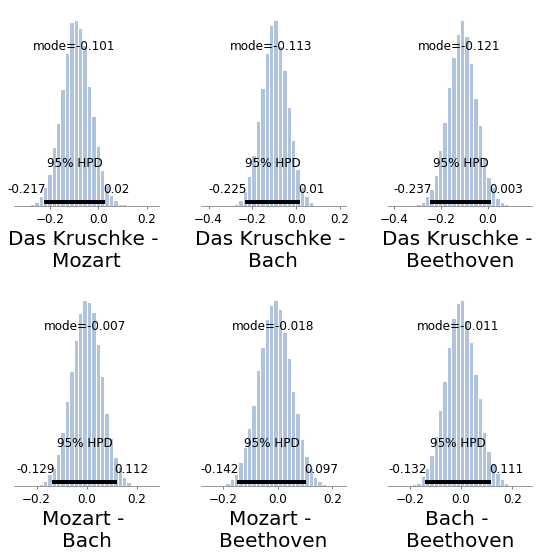

In [31]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 3)

plots = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]

i = 0
j = 0

for plot in plots:
    ax = plt.subplot(gs[i,j])
    data = trace['omega'][:,plot[0]] - trace['omega'][:,plot[1]]
    pm.plots.plot_posterior(data, label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
    ax.set_xlabel(conversion[plot[0] + 1] + ' - \n' + conversion[plot[1] + 1])
    
    j += 1
    if j == 3:
        i += 1
        j = 0
    

plt.tight_layout()
plt.show()

Instead of comparing the means, here we compare the posterior $\omega$ for each trial condition. Conditions with Das Kruschke appears to be lower than the other conditions but 0 is included in the 95% HDI so it is not definitive. 

Below, is the model comparison approach. It compares the model with 4 different values for $\omega$ with the model with only 1 value. The 1 value model is preferred (85.7% to 14.3%). 

In [29]:
df = pm.trace_to_dataframe(trace)
df = df.set_index('models')

counts = Counter(df.index)
print("Different omega model =", counts[0] / (counts[0] + counts[1]) )
print("Same omega model =", counts[1] / (counts[0] + counts[1]) )

Different omega model = 0.14273333333333332
Same omega model = 0.8572666666666666


## Relations of Parameter Estimation and Model Comparison

1. Applying the methods described above can achieve different conclusions. One method is not uniquely better than the other but instead depends on the scenario. Model comparison focuses on the increase of the null value while parameter estimation factors in the whole distribution. Parameter estimation is more intuitive and easier to understand because it produces a distribution for the parameter. Model comparison, on the other hand, is useful under 2 conditions. 

    1. A null value for the parameter must be meaningful.
    2. The alternative distribution (hypothesis) must also be meaningful.

2. The Bayes' Factor using model comparison can be estimated as the change in the credibility of the null value of the parameter estiamtion. More specifically, it is the ratio of the prior distribution within the ROPE divided by the ratio of the posterior distribution within the ROPE. This is known as the Savage-Dicky method.

# Chapter 12: Exercises - NEED TO FINISH

## Exercise 12.1

Suppose we have a coin that is flipped 24 times and shows 7 heads.

A. According to the spike null hypothesis, for which the only credible value of θ is 0.5, what is the probability of the data? Hint: It is $\theta^z(1 − \theta)^{N−z}$. Compute the value.

Answer: 5.96e-08

In [3]:
N = 24
z = 7
theta = 0.5
credible = theta**z * (1-theta)**(N-z)
print("Credible Value = ", credible)

Credible Value =  5.960464477539063e-08


B.  Verify the result of the previous part by approximating a spike prior with a narrow beta distribution. Use a beta($\theta$|2000, 2000) prior.
Include the resulting graph in your report. What is the value of p(D) for this prior? Is it very close to the value computed for the exact spike prior in the previous part of this exercise? (It should be.) Explain why they are not exactly equal.

Answer: NOW SURE HOW TO ANSWER

In [36]:
N = 24
z = 7
a = b = 2000
with pm.Model() as model:
    
    # prior
    theta = pm.Beta('theta', a, b)
    
    # likelihood
    y = pm.Binomial('y', n = N, p = theta, observed = z)

    trace_spike = pm.sample(15000, tune=2000, burn=200, thin=10, progressbar = False, nuts_kwargs={'target_accept': 0.90})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__]


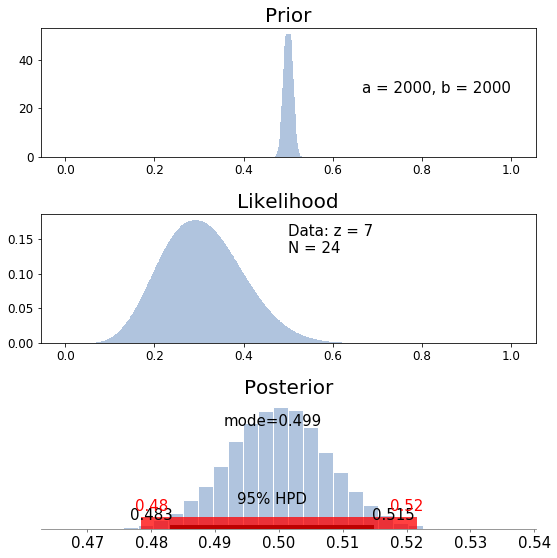

In [37]:
fig, axs = plt.subplots(3,1)

thetas = np.linspace(0,1,1000)
prior = beta(a,b)
likelihood = binom.pmf(k = z,n = N, p = thetas)

rope_low = 0.48
rope_high = 0.52

axs[0].bar(thetas, prior.pdf(thetas) , label='prior', width = 0.01, color = 'lightsteelblue');
axs[1].bar(thetas, likelihood, width = 0.01, color = 'lightsteelblue')
text = 'a = '+ str(a) + ', b = ' + str(b)
axs[0].annotate(text, xy=(0.65,0.5), xycoords="axes fraction")      
axs[1].annotate('Data: z = ' + str(z) + '\nN = ' + str(N), xy=(0.5,0.7), xycoords="axes fraction")      
pm.plot_posterior(trace_spike, rope = [rope_low,rope_high],point_estimate = 'mode', color=color, ax = axs[2]);
axs[0].set_title('Prior')
axs[1].set_title('Likelihood')
axs[2].set_title('Posterior')
fig.tight_layout()

In [45]:
dist_spike = stats.kde.gaussian_kde(trace_spike['theta'])
print(quad(dist_spike, z/N-0.001, z/N+0.001)[0])

0.0


C.  Show the result when using a nearly Haldane prior. Include the resulting graph in your report. What is the value of p(D) for this prior? Compute and report the Bayes’ factor of this prior relative to the spike (null) prior, using the formula $\frac{p(D|Haldane)}{p(D|null)}$.

Answer: NOT SURE HOW TO ANSWER

In [32]:
N = 24
z = 7
a = b = 0.01

with pm.Model() as model:
    
    # prior
    theta = pm.Beta('theta', a, b)
    
    # likelihood
    y = pm.Binomial('y', n = N, p = theta, observed = z)
    
    trace_haldane = pm.sample(15000, tune=2000, burn=200, thin=10, progressbar = False, nuts_kwargs={'target_accept': 0.90})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__]


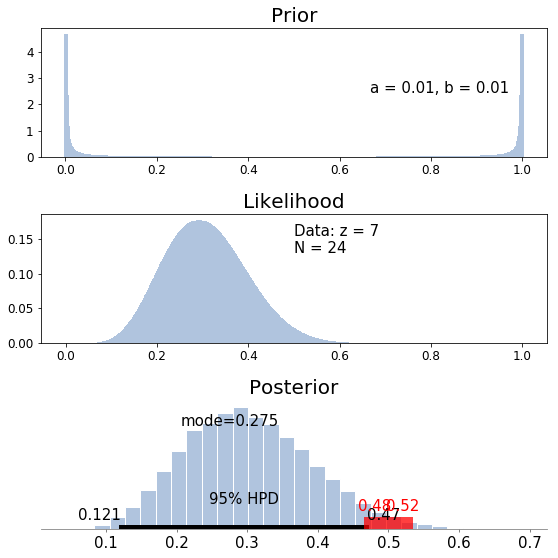

In [33]:
fig, axs = plt.subplots(3,1)
thetas = np.linspace(0,1,1000)

prior = beta(a,b)
likelihood = binom.pmf(k = z,n = N, p = thetas)

rope_low = 0.48
rope_high = 0.52

axs[0].bar(thetas, prior.pdf(thetas) , label='prior', width = 0.01, color = 'lightsteelblue');
axs[1].bar(thetas,likelihood, width = 0.01, color = 'lightsteelblue')
text = 'a = '+ str(a) + ', b = ' + str(b)
axs[0].annotate(text, xy=(0.65,0.5), xycoords="axes fraction")      
axs[1].annotate('Data: z = ' + str(z) + '\nN = ' + str(N), xy=(0.5,0.7), xycoords="axes fraction")      
pm.plot_posterior(trace_haldane, rope = [rope_low,rope_high],point_estimate = 'mode', color=color, ax = axs[2]);

axs[0].set_title('Prior')
axs[1].set_title('Likelihood')
axs[2].set_title('Posterior')
fig.tight_layout()

In [50]:
dist_haldane = stats.kde.gaussian_kde(trace_haldane['theta'])
print(quad(dist_haldane, z/N-0.00000000001, z/N+0.00000000001)[0])

8.404328614010011e-11


D. Continuing with the Haldane prior from the previous part, compute the approximate Bayes’ factor using the Savage-Dickey method. That is, compute and report the ratio of percentage of prior within the ROPE over percentage of posterior with the ROPE.

Answer: The Bayes' Factor is 0.046

In [35]:
prior_ratio = quad(prior.pdf, rope_low, rope_high)[0]
posterior_ratio = dist_haldane.integrate_box(rope_low,rope_high)
ratio = prior_ratio / posterior_ratio
print('Bayes Factor =', ratio)

Bayes Factor = 0.04606976422363162


E. Suppose we have previous knowledge that in this application there tend to be more tails than heads. Show the result when using a mildly informed prior. Include the resulting graph in your report. What is the value of p(D) for this prior? Compute and report the Bayes’ factor of this prior relative to the spike (null) prior, using the formula $\frac{p(D|Informed)}{p(D|null)}$.

Answer: Don't know p(D) and don't know bayes NEED TO FACTOR

In [53]:
N = 24
z = 7
a = 2
b = 4
with pm.Model() as model:
    
    # prior
    theta = pm.Beta('theta', a, b)
    
    # likelihood
    y = pm.Binomial('y', n = N, p = theta, observed = z)
    
    trace_informed = pm.sample(15000, tune=2000, burn=200, thin=10, progressbar = False, nuts_kwargs={'target_accept': 0.90})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__]


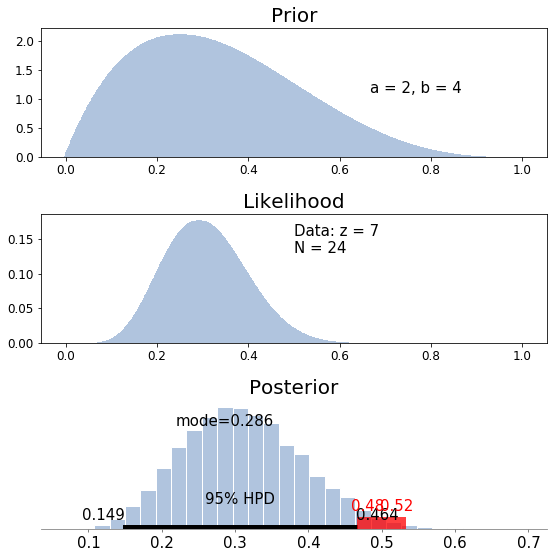

In [54]:
fig, axs = plt.subplots(3,1)
thetas = np.linspace(0,1,1000)

prior = beta(a,b)
likelihood = binom.pmf(k = z,n = N, p = thetas)

rope_low = 0.48
rope_high = 0.52

axs[0].bar(thetas, prior.pdf(thetas) , label='prior', width = 0.01, color = 'lightsteelblue');
axs[1].bar(thetas,likelihood, width = 0.01, color = 'lightsteelblue')
text = 'a = '+ str(a) + ', b = ' + str(b)
axs[0].annotate(text, xy=(0.65,0.5), xycoords="axes fraction")      
axs[1].annotate('Data: z = ' + str(z) + '\nN = ' + str(N), xy=(0.5,0.7), xycoords="axes fraction")      
pm.plot_posterior(trace_informed, rope = [rope_low,rope_high],point_estimate = 'mode', color=color, ax = axs[2]);

axs[0].set_title('Prior')
axs[1].set_title('Likelihood')
axs[2].set_title('Posterior')
fig.tight_layout()

F. Continuing with the mildly informed prior from the previous part, compute the approximate Bayes’ factor using the Savage-Dickey method. That is, compute and report the ratio of percentage of prior within the ROPE over percentage of posterior with the ROPE.

Answer. The Bayes' Factor is 3.635. It is close to the above calculated value.

In [57]:
dist_informed = stats.kde.gaussian_kde(trace_informed['theta'])
prior_ratio = quad(prior.pdf, rope_low, rope_high)[0]
posterior_ratio = dist_informed.integrate_box(rope_low,rope_high)
ratio = prior_ratio / posterior_ratio
print('Bayes Factor =', ratio)

Bayes Factor = 3.6355559039030525


G. Report the 95% HDIs when starting with the Haldane prior and the mildly informed prior. Are the HDIs very different? Were the Bayes’ factors very different?

Answer: The HDI for the Haldane prior were [.121,.47] and the HDI for the informed prior is [.149,.464]. The HDIs are similar but the Bayes' Factor gives the opposite results.

H. Which approach, model comparison or estimation, seems most informative? Why? Within the model-comparison approach, which prior, uninformed Haldane or mildly informed, seems most meaningful? Why?

Answer: Estimation seems more informative because it actually tells us about the parameter. The informed prior is always better because by definition it is informed. The uninformed prior includes no previous information.

## Exercise 12.2 - NEED TO FINISH

A. For this part of the exercise, the goal is to reproduce the  ndings presented in Section 12.2.2.1. State what the two models are, and state which model is preferred and by how much.

Answers: This is done and answered above.

B. Continuing with the previous part, consider the graphs of differences of modes. What do they imply about differences between groups? Does this conclusion agree or disagree with the conclusion from the model comparison? How do you reconcile the conclusions? (Hint: The model index and the groups modes are all parameters being simultaneously estimated, so there is no contradiction. The parameters answer different questions; which questions?)

Answer: As mentioned above, it seems that subjects with Das Kruschke performed worse than subjects with other artists. The conclusion seems to disagree with the model comparison method. NOT SURE HOW TO FINISH THIS

C. For this part of the exercise, the goal is to compare the single-mode model against a different partitioning of the group modes. Instead of letting each group have its own distinct mode, we will allow a distinct mode for the first group, but restrict groups 2 through 4 to use a single mode.

In [22]:
# parameters form the book
aP, bP = 1., 1.
a0 = tt.as_tensor([.48*500, aP])      
b0 = tt.as_tensor([(1-.48)*500, bP])
aPs = [aP] * 4
bPs = [bP] * 4
a = tt.as_tensor(np.array(list(zip(aPs, [(.40*125), (.50*125), (.51*125), (.52*125)]))))
b = tt.as_tensor(np.array(list(zip(bPs, [(1-.40)*125, (1-.50)*125, (1-.51)*125, (1-.52)*125]))))  
model_priors = np.array([0.5,0.5]) # priors for each model

with pm.Model() as model_1:
    
    models = pm.Categorical('models', model_priors)
    
    # condition parameters
    kappa = pm.Gamma('kappa', 2.618, 0.0809, shape=Number_Conditions)
    
    # condition 1 model - omega for each condition is different (index 1)
    omega = pm.Beta('omega', a[:,models], b[:,models], shape=Number_Conditions)
    
    # condition 2 model - omega for each condition is same (index 2,3,4)
    omega0 = pm.Beta('omega0', a0[models], b0[models])    
        
    aBeta = pm.math.switch(pm.math.eq(models, 0), omega * (kappa-2) + 1, omega0 * (kappa-2) + 1)
    bBeta = pm.math.switch(pm.math.eq(models, 0), (1-omega) * (kappa-2) + 1, (1-omega0) * (kappa-2) + 1)

    # distributio of theta
    theta = pm.Beta('theta', aBeta[CondOfSubj], bBeta[CondOfSubj], shape=Number_Subjects)
    
    # Likelihood
    y = pm.Binomial('y', n=df.nTrlOfSubj.values, p=theta, observed=df.nCorrOfSubj)
    
    trace = pm.sample(10000, tune=1000, burn=200, thin=10, progressbar = True ,nuts_kwargs={'target_accept': 0.90})


ValueError: Input dimension mis-match. (input[0].shape[0] = 3, input[1].shape[0] = 4)

In [ ]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 3)

plots = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]

i = 0
j = 0

for plot in plots:
    ax = plt.subplot(gs[i,j])
    data = trace['omega'][:,plot[0]] - trace['omega'][:,plot[1]]
    pm.plots.plot_posterior(data, label='post', ax = ax, color = 'lightsteelblue', point_estimate = 'mode')
    ax.set_xlabel(conversion[plot[0] + 1] + ' - \n' + conversion[plot[1] + 1])
    
    j += 1
    if j == 3:
        i += 1
        j = 0
    

plt.tight_layout()
plt.show()